In [1]:
import torch

In [2]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchgeo.datasets import EuroSAT100
import torch.nn.functional as F

In [3]:
import numpy as np

In [4]:
data = [[1,2],[3,4]]

In [5]:
x_data = torch.tensor(data)

In [6]:
x_data

tensor([[1, 2],
        [3, 4]])

In [7]:
nparray = np.array(data)

In [8]:
nparray

array([[1, 2],
       [3, 4]])

In [9]:
x_np = torch.from_numpy(nparray)

In [10]:
x_np

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

In [3]:
training_data = EuroSAT100(
    root = "data",
    split = "train",
    download = True
)

100%|████████████████████████████████████████████████████████████████████████████████| 7717354/7717354 [00:02<00:00, 3787446.74it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:00<00:00, 424702.31it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 336634.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 80590.72it/s]


In [4]:
test_data = EuroSAT100(
    root = "data",
    split = "val",
    download = True
)

In [5]:
labels_map = {
    0: "Annual Crop",
    1: "Forest",
    2: "Herbaceous Vegetation",
    3: "Highway",
    4: "Industrial Buildings",
    5: "Pasture",
    6: "Permanent Crop",
    7: "Residential Buildings",
    8: "River",
    9: "Sea & Lake"
}

In [6]:
import matplotlib.pyplot as plt

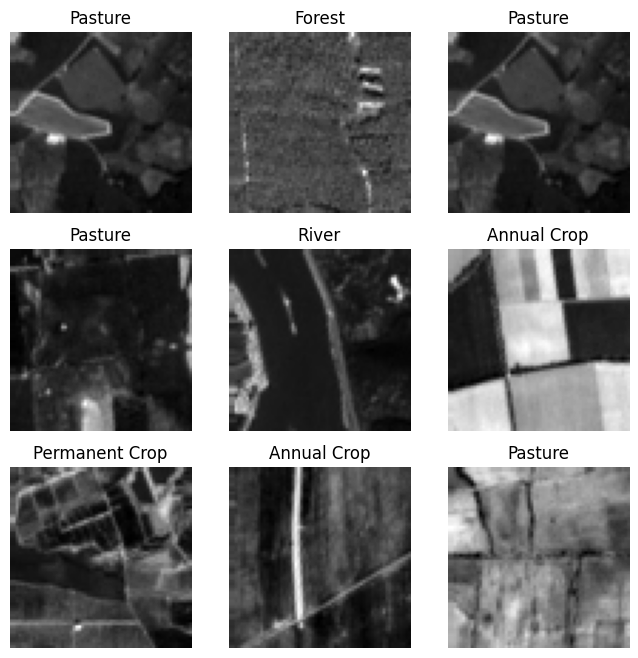

In [11]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    data = training_data[sample_idx]
    img, label = data['image'], data['label'].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[3], cmap="gray")
plt.show()    

In [13]:
training_data[0]['image'].shape #each image has 13 bands of 64 by 64 pixels

torch.Size([13, 64, 64])

In [15]:
batch_size = 4

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

for data in test_dataloader:
    X = data['image']
    y = data['label']
    print(f"Shape of X [Number, Channel, Heoight, Width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [Number, Channel, Heoight, Width]: torch.Size([4, 13, 64, 64])
Shape of y: torch.Size([4]) torch.int64


In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [46]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(13 * 64 * 64, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [92]:
device='cuda:0'

In [93]:
model = NeuralNetwork().to(device)

In [94]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=53248, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [95]:
loss_fn = nn.CrossEntropyLoss()
optimier = torch.optim.SGD(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, img_data in enumerate(dataloader):
        X = img_data['image']
        y = img_data['label']
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 4 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/ {size:>5d}]")

In [96]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for img_data in dataloader:
            X = img_data['image']
            y = img_data['label']

            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /=  num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [98]:
import datetime

In [99]:
now = datetime.datetime.now()
print(datetime.datetime.now())
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1} \n---------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print(datetime.datetime.now() - now)
print("Done!")    

2024-08-24 20:32:13.264167
Epoch 1 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 414.959448 

Epoch 2 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 437.329333 

Epoch 3 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 342.696039 

Epoch 4 
---------------------------------
Test Error: 
 Accuracy: 15.0%, Avg loss: 615.600958 

Epoch 5 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 533.342310 

Epoch 6 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 369.232654 

Epoch 7 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 433.361475 

Epoch 8 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 317.279420 

Epoch 9 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 300.199312 

Epoch 10 
---------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 304.388911 

0:

In [137]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
model.eval()
X = test_data[sample_idx]['image']
y = test_data[sample_idx]['label']
with  torch.no_grad():
    X = X.unsqueeze(0)
    X = X.to(device)
    pred = model(X)
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y.item()]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')



Predicted: "Herbaceous Vegetation", Actual: "River"


Predicted: "2", Actual: "River"


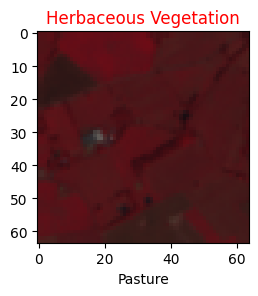

In [138]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
model.eval()
X = test_data[sample_idx]['image']
y = test_data[sample_idx]['label']
with torch.no_grad():
    X = X.unsqueeze(0)    
    X = X.to(device)
    pred = model(X)
    predicted = pred[0].argmax(0).cpu().item()
    if predicted == y:
        color = 'green'
    else:
        color = 'red'

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.grid(False)
plt.axis()
test_img = torch.stack((X[0][7], X[0][3], X[0][2]), dim=0)
test_img = torch.permute(test_img, (1,2,0))
plt.imshow(test_img.cpu()/10000, cmap='gray')
plt.title(labels_map[predicted], color=color)
plt.xlabel(labels_map[y.item()])
print(f'Predicted: "{predicted}", Actual: "{actual}"')